# COVID-19 New Cases on Country Graph

Loads an undirected, weighted country proximity graph from `data/country_proximity_edges.csv`, uses real 2020 country populations from `data/world_population.csv` as the fixed starting population per node, and runs a simple SIR-style spread to estimate daily new cases and total cases.

KISS:
- Minimal dependencies: pandas, numpy, matplotlib.
- Flexible column inference for both CSVs.
- Population taken once at t=0 from 2020; not updated dynamically.
- Focus on new daily cases and cumulative totals (no S/R plots).

How to run:
1. Run cells top-to-bottom.
2. Adjust parameters (infection/recovery/mixing, seeds).
3. Re-run the simulation and plots.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True


In [2]:
# Load edges CSV (supports Spanish column names)
csv_path = 'data/country_proximity_edges.csv'
df = pd.read_csv(csv_path)
print(f'Loaded {len(df):,} edges from {csv_path}')
df.head(3)


Loaded 25,425 edges from data/country_proximity_edges.csv


,Pais_A,Pais_B,Distancia_km,Proximidad
0,Azerbaijan,Afghanistan,1910.121312,0.904283
1,Azerbaijan,Albania,2305.532584,0.884468
2,Azerbaijan,Algeria,4384.207506,0.780305


In [3]:
# Build undirected weighted adjacency from the dataframe
def infer_edge_columns(df):
    candidates = [
        ('Pais_A', 'Pais_B', 'Proximidad'),
        ('source', 'target', 'weight'),
        ('Country_A', 'Country_B', 'Proximity'),
        ('u', 'v', 'w'),
    ]
    for a,b,w in candidates:
        if all(c in df.columns for c in (a,b,w)):
            return a,b,w
    # Fallback: guess two string/object columns and one numeric as weight
    obj_cols = [c for c in df.columns if df[c].dtype == 'object']
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    if len(obj_cols) >= 2 and len(num_cols) >= 1:
        return obj_cols[0], obj_cols[1], num_cols[0]
    raise ValueError('Could not infer edge columns. Expected two string columns and one numeric weight.')

col_u, col_v, col_w = infer_edge_columns(df)
print(f'Using columns: {col_u}, {col_v} with weight {col_w}')

# Collect nodes
nodes = pd.Index(pd.unique(pd.concat([df[col_u], df[col_v]]))).sort_values()
node_to_idx = {n:i for i,n in enumerate(nodes)}
idx_to_node = {i:n for n,i in node_to_idx.items()}
n = len(nodes)
print(f'Found {n} nodes (countries)')

# Adjacency with raw weights (undirected)
adj = defaultdict(dict)
for a, b, w in df[[col_u, col_v, col_w]].itertuples(index=False):
    if a == b:
        continue
    wa = float(w)
    if wa <= 0:
        continue
    # Keep the max weight if duplicates exist
    adj[a][b] = max(wa, adj[a].get(b, 0.0))
    adj[b][a] = max(wa, adj[b].get(a, 0.0))

# Build normalized neighbor weights per node (sum to 1)
neighbors = {u: list(adj[u].keys()) for u in nodes}
weights = {}
for u in nodes:
    ws = np.array([adj[u][v] for v in neighbors[u]], dtype=float)
    s = ws.sum()
    if s > 0:
        ws = ws / s
    weights[u] = ws

print('Example neighbors:', list(neighbors.items())[:3])


Using columns: Pais_A, Pais_B with weight Proximidad
Found 226 nodes (countries)
Example neighbors: [('Afghanistan', ['Azerbaijan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'Fin

In [4]:
# Load 2020 populations and build per-node population vector N
pop_csv = 'data/world_population.csv'
df_pop = pd.read_csv(pop_csv)

def infer_population_columns(df):
    # Prefer 2020 population
    pop_candidates = ['2020 Population', 'Population (2020)', '2020', 'Pop2020', 'Population_2020']
    name_candidates = ['Country/Territory', 'Country', 'Name', 'country', 'Country Name']
    pop_col = next((c for c in pop_candidates if c in df.columns), None)
    name_col = next((c for c in name_candidates if c in df.columns), None)
    if pop_col is None or name_col is None:
        raise ValueError('Could not infer population columns. Expected a country name column and a 2020 population column.')
    return name_col, pop_col

name_col, pop_col = infer_population_columns(df_pop)
print(f'Using population columns: name={name_col}, pop={pop_col}')

import unicodedata, re
def canon(s: str) -> str:
    if not isinstance(s, str):
        s = ''
    s = s.strip().lower()
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    s = s.replace('&', ' and ')
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\bthe\b', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # Normalize common ordering variants
    s = s.replace('korea south', 'south korea').replace('korea north', 'north korea')
    s = s.replace('bahamas the', 'bahamas')
    return s

alias = {
    'czechia': 'czech republic',
    'lao pdr': 'laos',
    'lao people s democratic republic': 'laos',
    'cote d ivoire': 'ivory coast',
    'cote divoire': 'ivory coast',
    'cabo verde': 'cape verde',
    'swaziland': 'eswatini',
    'united states of america': 'united states',
    'u s a': 'united states', 'u s': 'united states', 'usa': 'united states', 'us': 'united states',
    'uk': 'united kingdom', 'great britain': 'united kingdom', 'gb': 'united kingdom',
    'holy see': 'vatican city',
    'east timor': 'timor leste',
    'congo dem rep': 'dr congo', 'congo democratic republic': 'dr congo', 'congo kinshasa': 'dr congo', 'democratic republic of congo': 'dr congo',
    'congo rep': 'republic of the congo', 'congo brazzaville': 'republic of the congo'
}

# Build canonical -> population (float)
pop_by_canon = {}
for row in df_pop[[name_col, pop_col]].itertuples(index=False):
    nm = canon(row[0])
    pop = float(row[1])
    pop_by_canon[nm] = pop

# Map graph node names to populations
fallback_pop = 100_000.0  # used only if a country name fails to match
N = np.zeros(n, dtype=float)
unmatched = []
matched = 0
for i, node in enumerate(nodes):
    c = canon(node)
    c = alias.get(c, c)
    pop = pop_by_canon.get(c)
    if pop is None:
        # Fallback keeps simulation running even if a few names differ
        N[i] = fallback_pop
        unmatched.append(node)
    else:
        N[i] = pop
        matched += 1

print(f'Matched population for {matched}/{n} nodes. Unmatched: {len(unmatched)}')
if unmatched:
    print('Examples of unmatched (first 15):', unmatched[:15])


Using population columns: name=Country/Territory, pop=2020 Population
Matched population for 214/226 nodes. Unmatched: 12
Examples of unmatched (first 15): ['Burma', 'Channel Islands', 'Congo (Brazzaville)', 'Diamond Princess', 'Kosovo', 'MS Zaandam', 'Mainland China', 'North Ireland', 'Others', 'Republic of Ireland', 'West Bank and Gaza', 'occupied Palestinian territory']


In [45]:
# Parameters (tune as needed)
T = 200          # time steps
dt = 1.0         # time step size (days)
beta = 0.25      # infection rate
gamma = 0.1      # recovery rate
mu = 0.03        # cross-border mixing weight (0 = no cross-border spread)

# Initial seeds: either a single string or a list of strings
seed_countries = ['China']  # if not present, will fallback to the first node
seed_infected = 25

print({
    'T': T, 'dt': dt, 'beta': beta, 'gamma': gamma, 'mu': mu,
    'seed_countries': seed_countries, 'seed_infected': seed_infected
})


{'T': 200, 'dt': 1.0, 'beta': 0.25, 'gamma': 0.1, 'mu': 0.03, 'seed_countries': ['China'], 'seed_infected': 25}


In [46]:
# Initialize compartments (S and R are internal only; we focus on new cases)
S0 = N.copy()
I0 = np.zeros(n, dtype=float)
R0 = np.zeros(n, dtype=float)

if isinstance(seed_countries, str):
    seed_countries = [seed_countries]

seeded = []
for name in seed_countries:
    if name in node_to_idx:
        i = node_to_idx[name]
    else:
        # Fallback to the first node if specified seed not found
        i = 0
        name = idx_to_node[i]
    I0[i] += seed_infected
    S0[i] = max(0.0, S0[i] - seed_infected)
    seeded.append(name)

print(f'Seeded infected in: {seeded}')
print(f'Total initial infected: {I0.sum():.0f}')


Seeded infected in: ['China']
Total initial infected: 25


In [47]:
# SIR simulation with cross-border mixing; return daily new cases and I history
def run_sir_with_cases(S0, I0, R0, N, beta, gamma, mu, dt, T, neighbors, weights, node_order):
    n = len(node_order)
    S = S0.astype(float).copy()
    I = I0.astype(float).copy()
    R = R0.astype(float).copy()

    hist_I = np.zeros((T+1, n), dtype=float)
    daily_new_cases = np.zeros((T, n), dtype=float)

    hist_I[0] = I

    for t in range(1, T+1):
        frac_I = np.divide(I, N, out=np.zeros_like(I), where=N>0)
        cross = np.zeros(n, dtype=float)
        # Compute cross-border infection pressure via normalized neighbor weights
        for idx, u in enumerate(node_order):
            ns = neighbors[u]
            if not ns:
                continue
            w = weights[u]
            nbr_idx = [node_to_idx[v] for v in ns]
            cross[idx] = (frac_I[nbr_idx] * w).sum()

        # Force of infection lambda per node
        lam = beta * (frac_I + mu * cross)
        new_inf = dt * lam * S
        new_inf = np.minimum(new_inf, S)

        new_rec = dt * gamma * I
        new_rec = np.minimum(new_rec, I)

        S = S - new_inf
        I = I + new_inf - new_rec
        R = R + new_rec

        hist_I[t] = I
        daily_new_cases[t-1] = new_inf

    return hist_I, daily_new_cases

hist_I, daily_new_cases = run_sir_with_cases(S0, I0, R0, N, beta, gamma, mu, dt, T, neighbors, weights, list(nodes))
print('Simulation done.')

# Global metrics (new cases only)
tot_daily_new = daily_new_cases.sum(axis=1)
cum_daily_new = tot_daily_new.cumsum()
peak_new = tot_daily_new.max()
peak_t = tot_daily_new.argmax()
print(f'Peak daily new cases: {peak_new:.0f} at t={peak_t}')


Simulation done.
Peak daily new cases: 198523169 at t=158


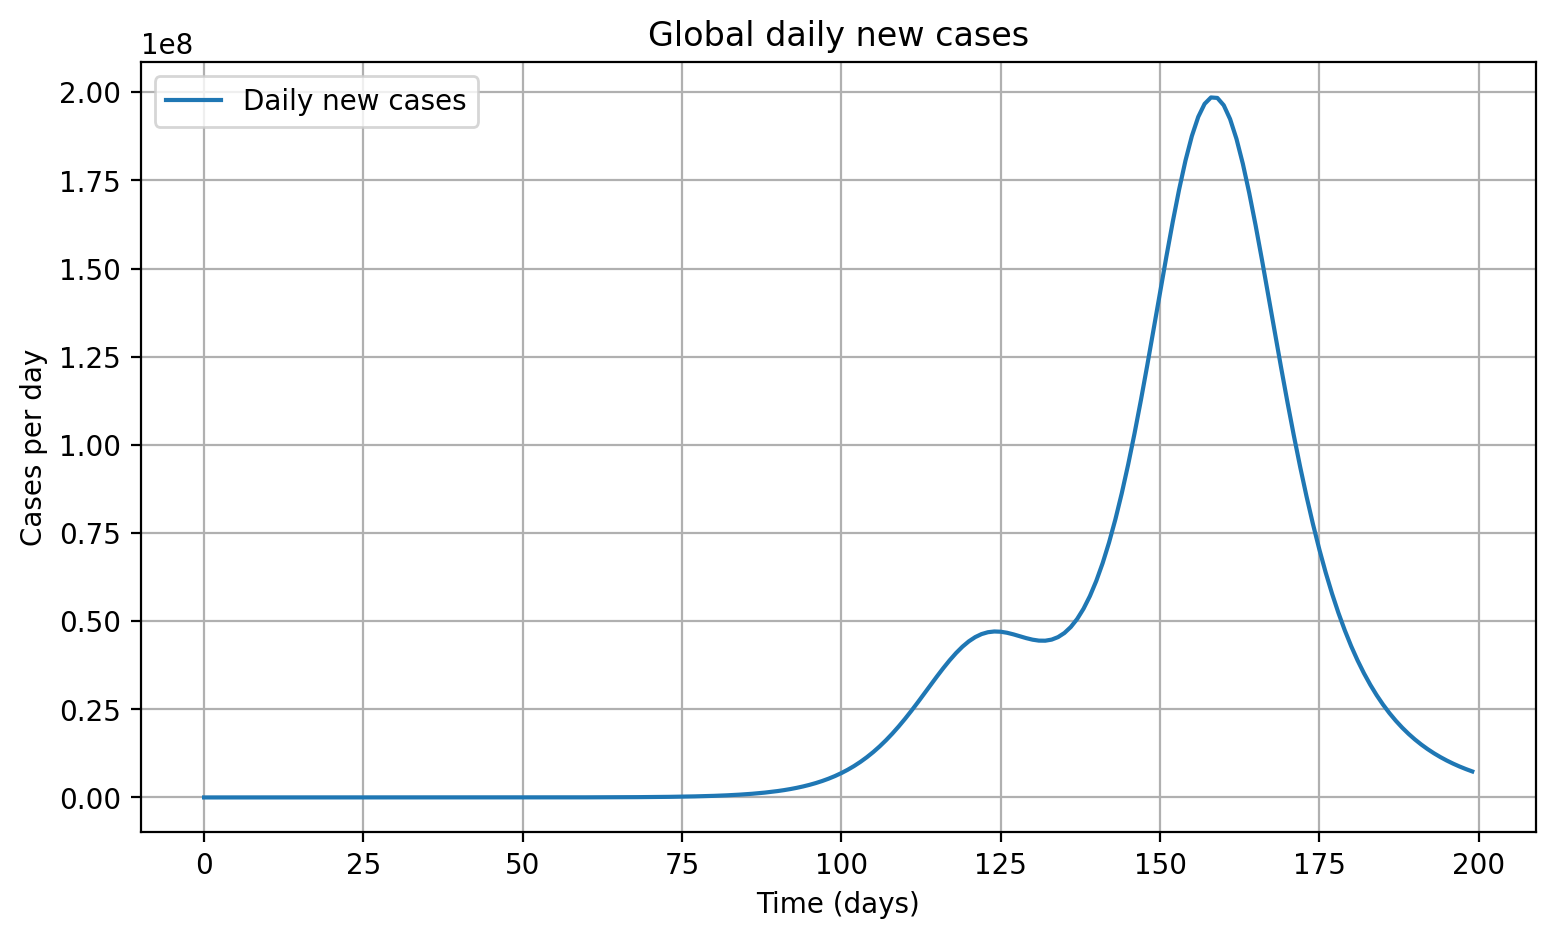

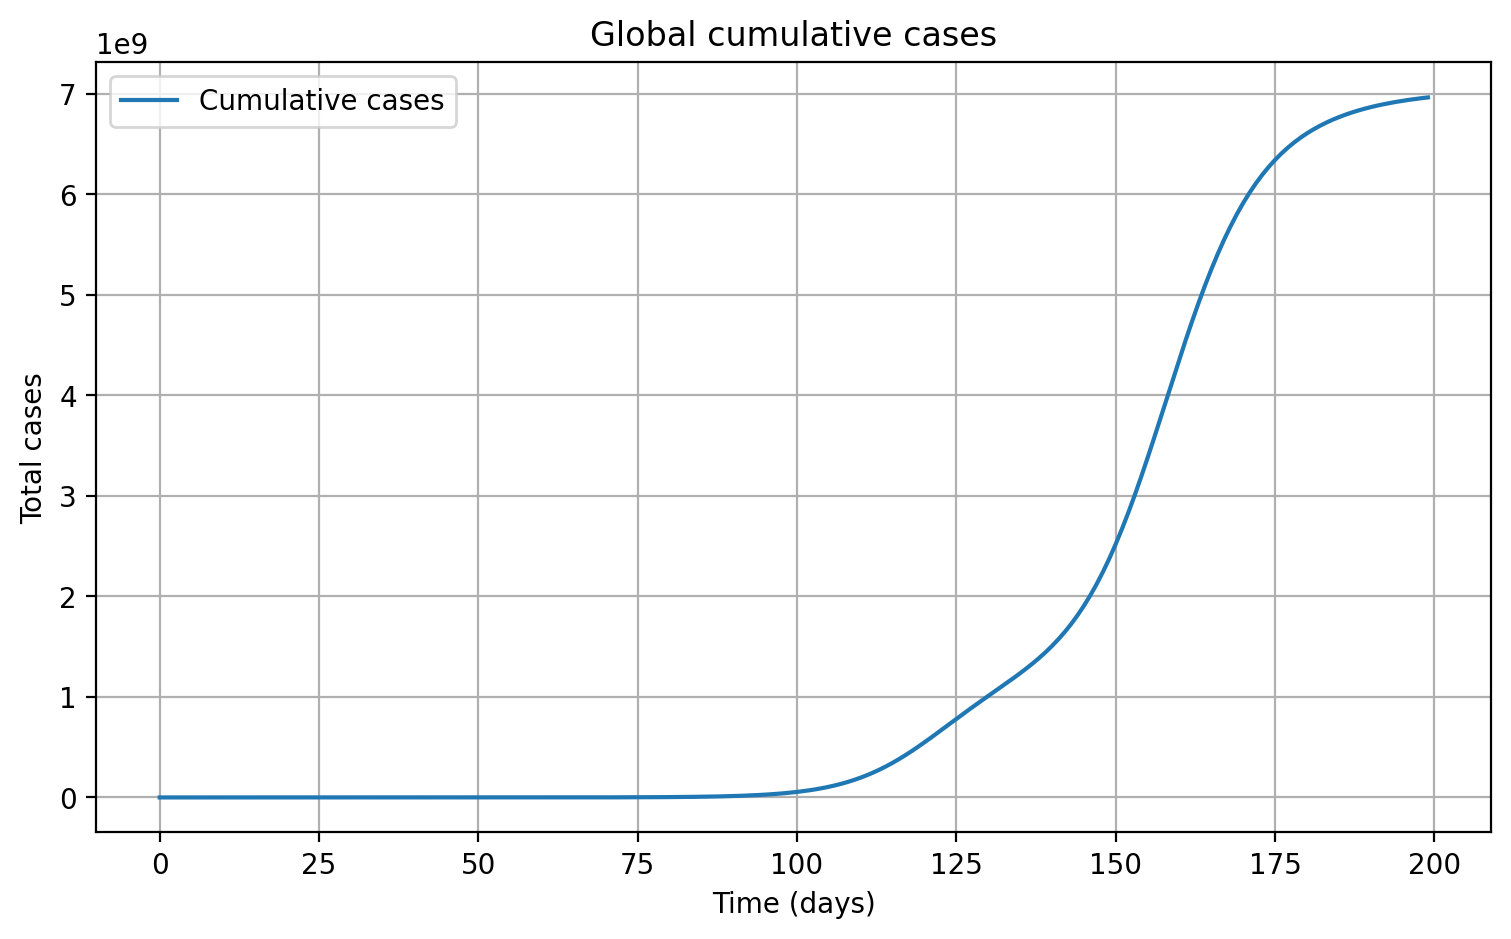

In [48]:
# Plot global daily new and cumulative cases
t = np.arange(T)
plt.figure()
plt.plot(t, tot_daily_new, label='Daily new cases')
plt.xlabel('Time (days)')
plt.ylabel('Cases per day')
plt.title('Global daily new cases')
plt.legend()
plt.show()

plt.figure()
plt.plot(t, cum_daily_new, label='Cumulative cases')
plt.xlabel('Time (days)')
plt.ylabel('Total cases')
plt.title('Global cumulative cases')
plt.legend()
plt.show()


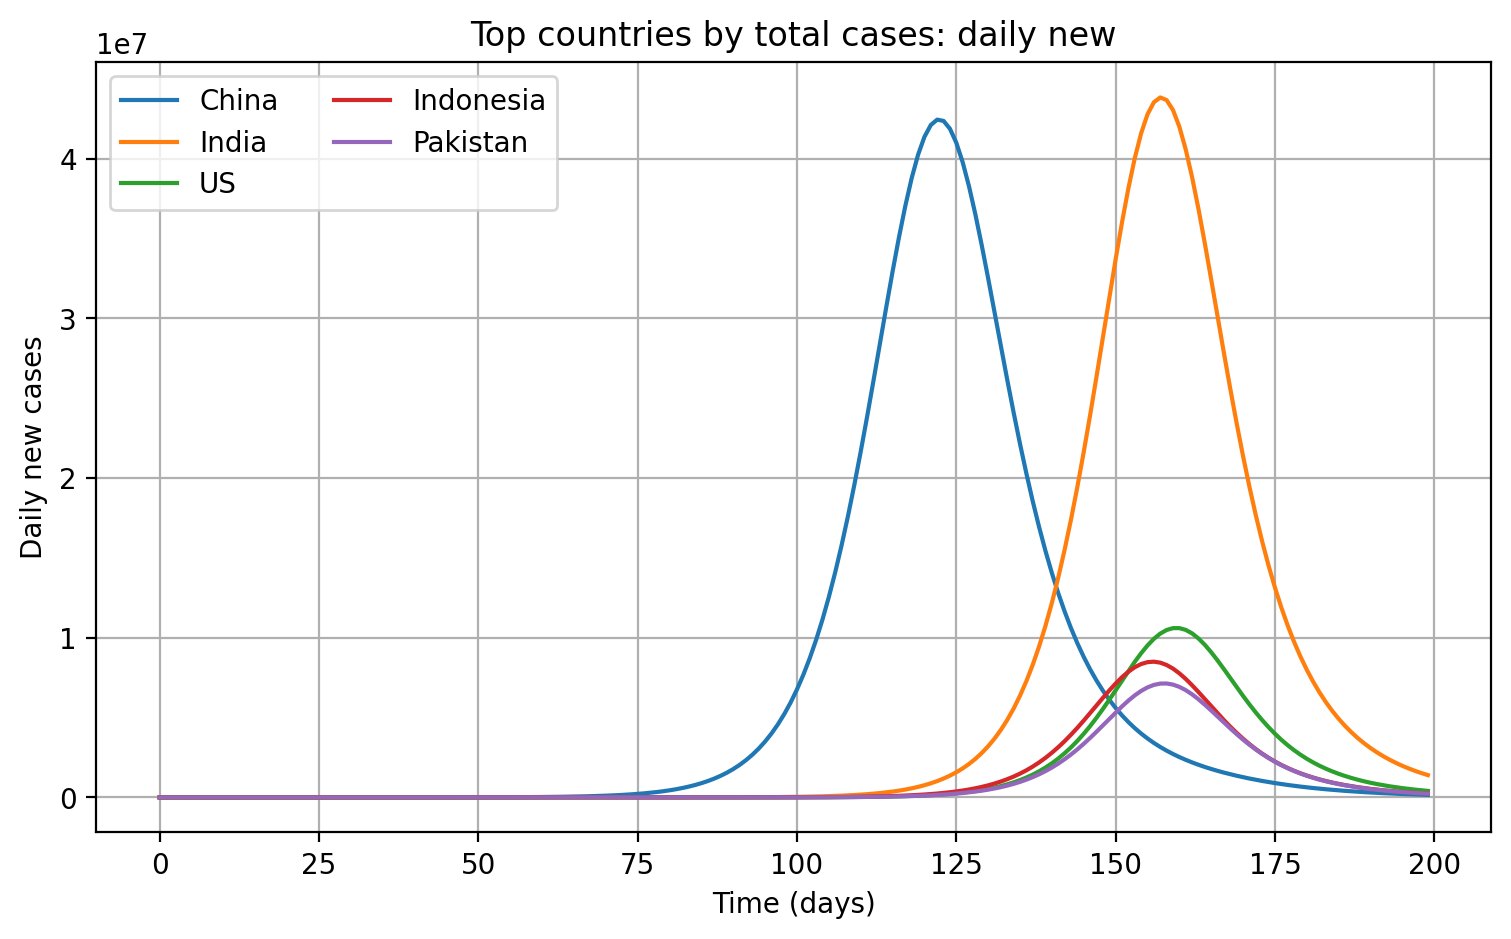

,country,total_cases,peak_daily_new,peak_day
41,China,1.291583e+09,4.245432e+07,122
94,India,1.252296e+09,4.384433e+07,157
211,US,3.004800e+08,1.060601e+07,160
95,Indonesia,2.441091e+08,8.503687e+06,156
155,Pakistan,2.036622e+08,7.137486e+06,158
25,Brazil,1.897322e+08,6.834263e+06,163
149,Nigeria,1.861904e+08,6.607684e+06,160
15,Bangladesh,1.502218e+08,5.243606e+06,157
170,Russia,1.306017e+08,4.568154e+06,157
135,Mexico,1.126352e+08,3.988533e+06,160


In [49]:
# Top-5 countries by total cases and daily trend
total_cases_by_country = daily_new_cases.sum(axis=0)
topk = min(5, len(nodes))
top_idx = np.argsort(-total_cases_by_country)[:topk]
top_names = [idx_to_node[i] for i in top_idx]

plt.figure()
for i,name in zip(top_idx, top_names):
    plt.plot(np.arange(T), daily_new_cases[:, i], label=name)
plt.xlabel('Time (days)')
plt.ylabel('Daily new cases')
plt.title('Top countries by total cases: daily new')
plt.legend(ncol=2)
plt.show()

summary = pd.DataFrame({
    'country': [idx_to_node[i] for i in range(len(nodes))],
    'total_cases': total_cases_by_country,
    'peak_daily_new': daily_new_cases.max(axis=0),
    'peak_day': daily_new_cases.argmax(axis=0)
}).sort_values('total_cases', ascending=False)
summary.head(10)
